# Импортирование

In [1]:
import kaggle
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

sns.set_style('darkgrid')

# Получение данных

Данные полученны с помощью kaggle.api

In [2]:
def load_data_from_kaggle(name_datasets):
    kaggle.api.authenticate()
    download_folder = 'datasets'
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)
        kaggle.api.competition_download_files(name_datasets, path=download_folder)
        archive_path = os.path.join(download_folder, f'{name_datasets}.zip')
        extract_folder = download_folder

        with zipfile.ZipFile(archive_path, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
        os.remove(archive_path)

In [3]:
name_datasets = 'house-prices-advanced-regression-techniques'
load_data_from_kaggle(name_datasets)

In [4]:
df = pd.read_csv("datasets/train.csv")

In [5]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Создание испытательного набора

Сделаем стратифицированную выборку

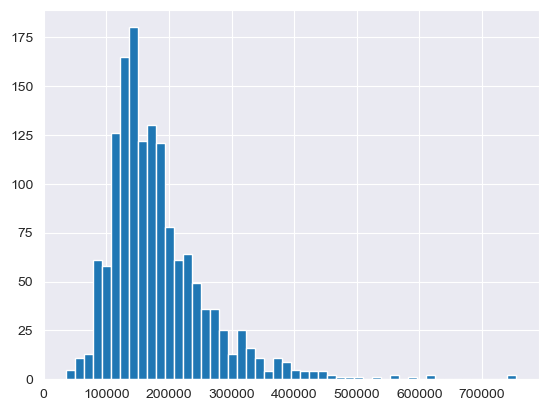

In [65]:
df['SalePrice'].hist(bins=50)
plt.show()

In [66]:
bins = [0, 100000, 150000, 200000, 300000, np.inf]
labels = [1, 2, 3, 4, 5]
df['saleprice_cut'] = pd.cut(df['SalePrice'], bins=bins, labels=labels)

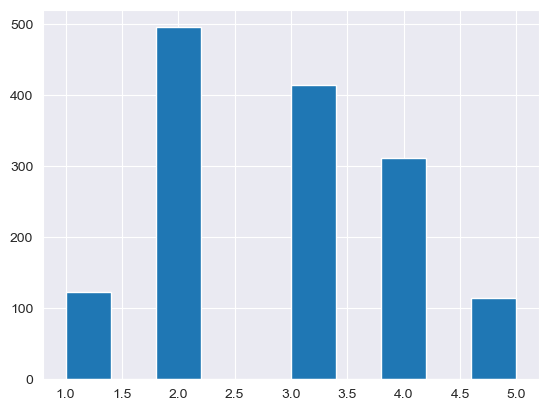

In [67]:
df['saleprice_cut'].hist()
plt.show()

Получаем разделение

In [68]:
strat_train_set, strat_test_set = train_test_split(
    df, test_size=0.2, stratify=df['saleprice_cut'], random_state=42)

Просмотр пропорций категорий цен на продажу

In [69]:
strat_test_set['saleprice_cut'].value_counts() / len(strat_test_set)

saleprice_cut
2    0.339041
3    0.284247
4    0.212329
1    0.085616
5    0.078767
Name: count, dtype: float64

Удаляем атрибут, чтобы возвратить данные на первоночальное состояние

In [70]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('saleprice_cut', axis=1, inplace=True)

# Изучение данных

Делаем копию данных. Поскольку мы собираемся экспериментировать с различными преобразованиями полного обучающего набора, нам следует сделать копию оригинала, чтобы впоследствии вернуться к нему

In [71]:
df_copy = strat_train_set.copy()

## Информация о числовых признаков

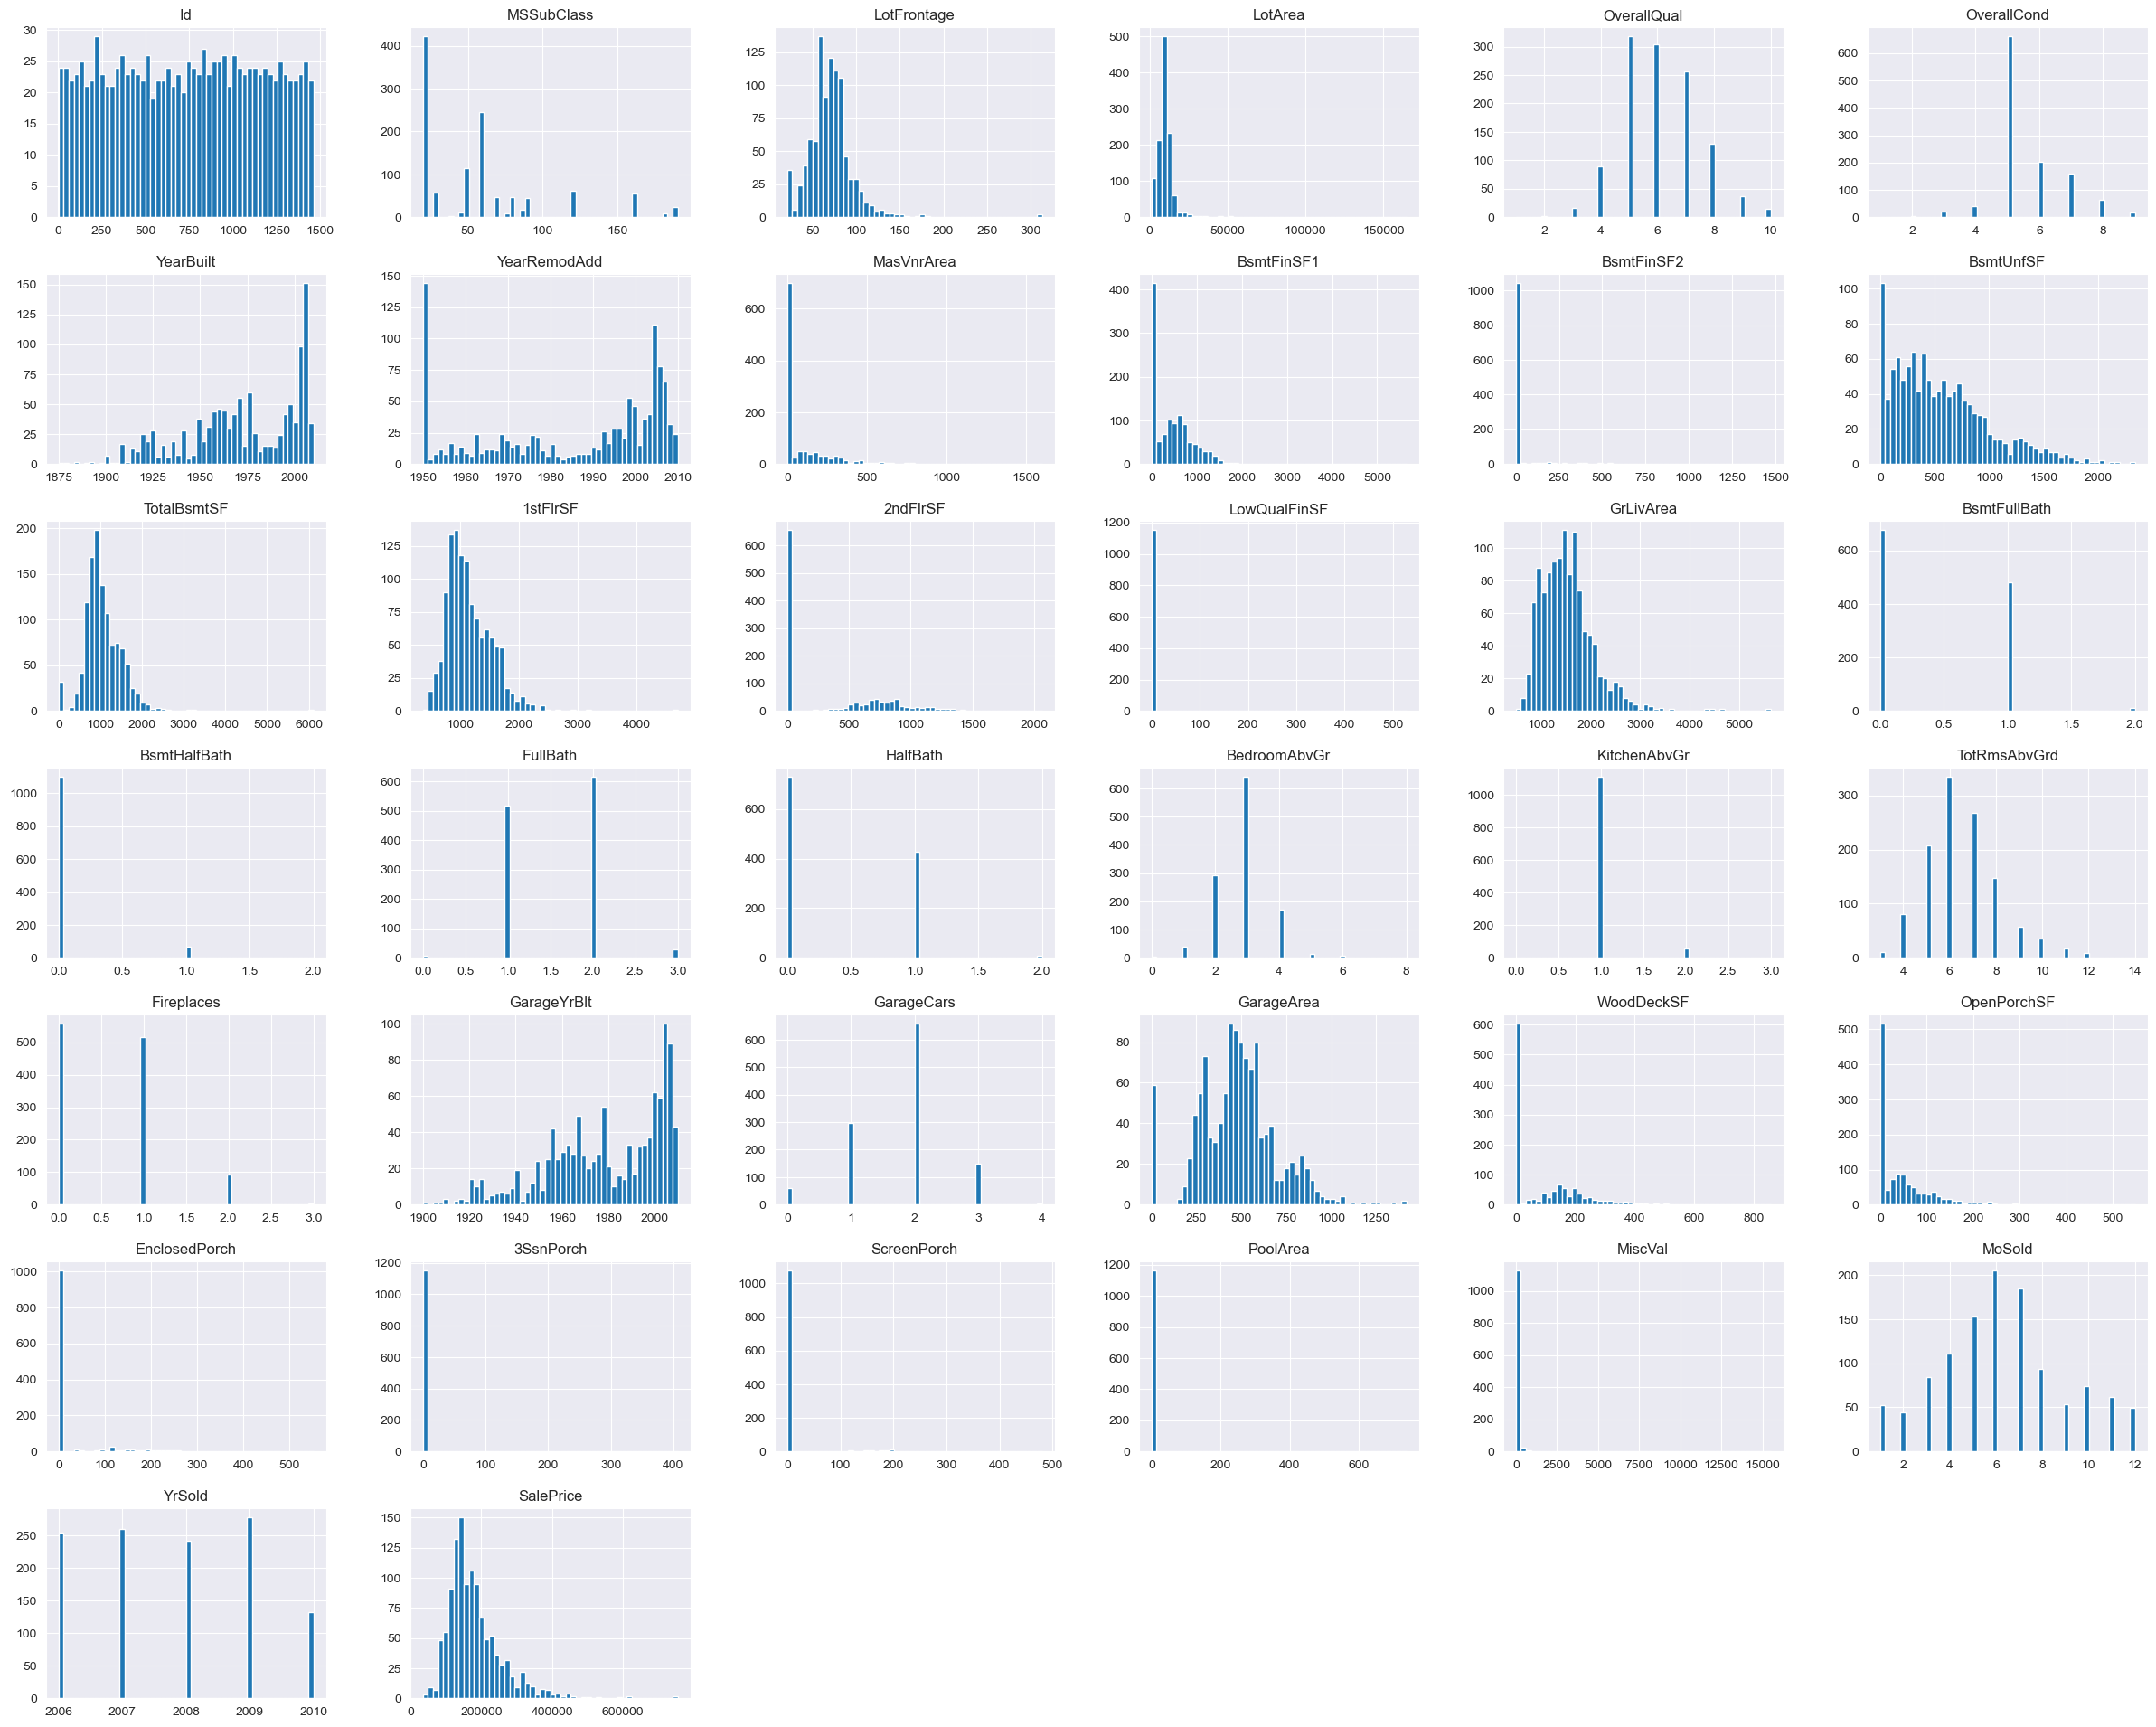

In [72]:
df_copy.hist(figsize=(30, 24), bins=50)
plt.show()

## Столбцы тип object

In [73]:
type_object = df_copy.select_dtypes(include=['object']).columns
type_object

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

## Cтолбцы тип int64

In [74]:
type_int64 = df_copy.select_dtypes(include=['int64']).columns
type_int64

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

## Столбцы тип float64

In [75]:
type_float64 = df_copy.select_dtypes(include=['float64']).columns
type_float64

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

## Пропущеные значения

% пустных значений в каждой колонке

In [76]:
def col_null(df):
    col_null = df.columns[df.isnull().any()]
    col_null = df[col_null].isnull().mean() * 100
    return col_null.sort_values(ascending=False)

In [77]:
col_null(df_copy)


PoolQC          99.486301
MiscFeature     96.404110
Alley           93.835616
Fence           80.308219
MasVnrType      59.075342
FireplaceQu     47.688356
LotFrontage     17.893836
GarageType       5.051370
GarageYrBlt      5.051370
GarageFinish     5.051370
GarageQual       5.051370
GarageCond       5.051370
BsmtFinType2     2.739726
BsmtExposure     2.739726
BsmtFinType1     2.654110
BsmtCond         2.654110
BsmtQual         2.654110
MasVnrArea       0.599315
Electrical       0.085616
dtype: float64

## Рассмотрение целевого признака SalePrice

In [78]:
df_copy['SalePrice'].describe()

count      1168.000000
mean     181145.985445
std       79271.523143
min       34900.000000
25%      130000.000000
50%      163945.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

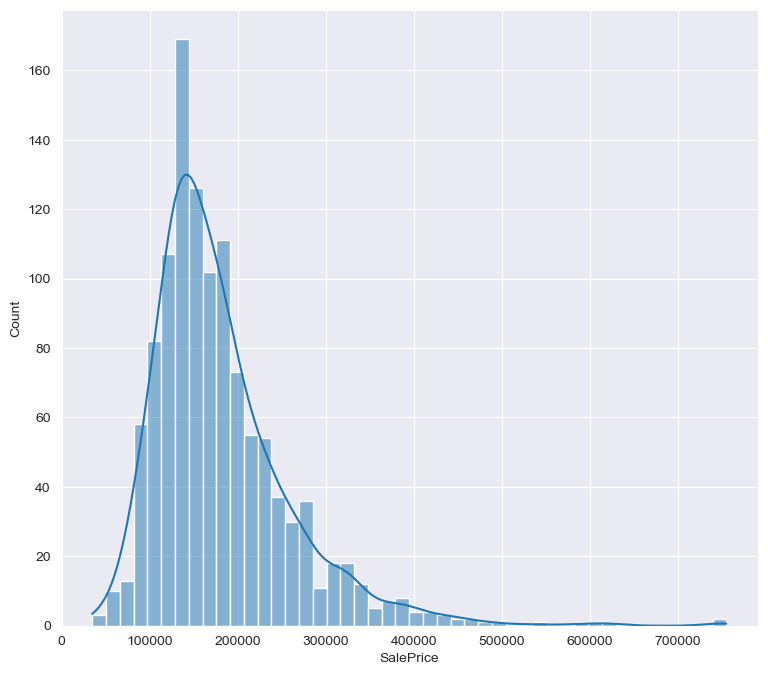

In [79]:
plt.figure(figsize=(9, 8))
sns.histplot(df_copy['SalePrice'], kde=True)
plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_11689/3076923577.py:6: SyntaxWarning: invalid escape sequence '\m'
  plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
/tmp/ipykernel_11689/3076923577.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_copy['SalePrice'] , fit=norm);



 mu = 181145.99 and sigma = 79237.58



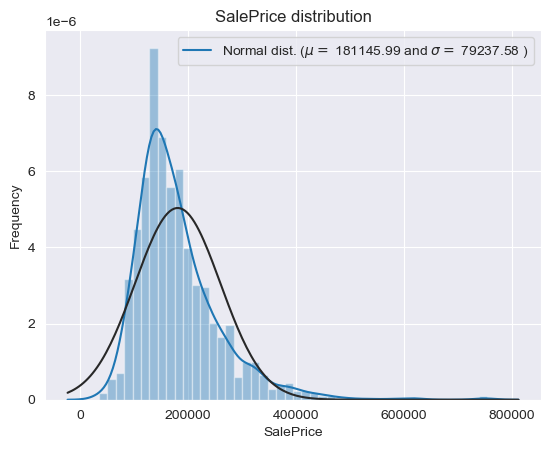

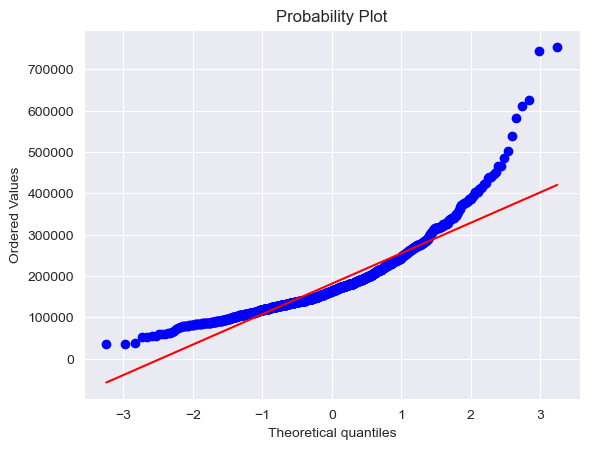

In [80]:
sns.distplot(df_copy['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(df_copy['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

plt.figure()
stats.probplot(df_copy['SalePrice'], plot=plt)

plt.show()

## Вычисляем стандартный коэффициент корреляции

<Axes: >

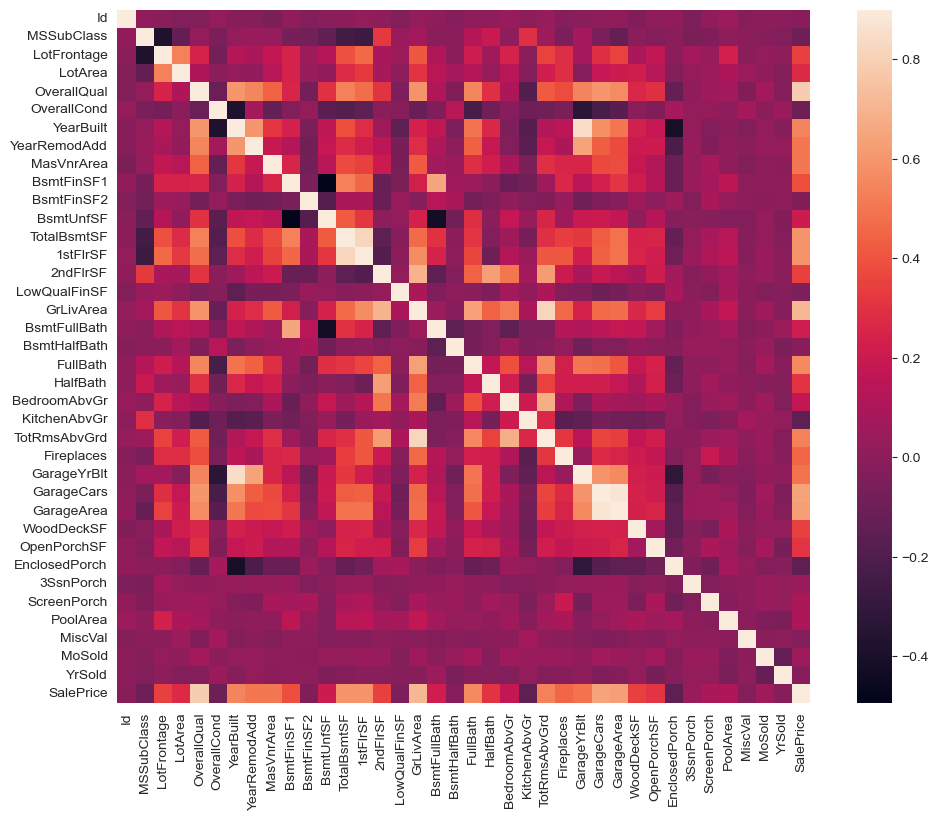

In [81]:
corr_matrix = df_copy.corr(numeric_only=True)
plt.subplots(figsize=(12,9))
sns.heatmap(corr_matrix, vmax=0.9, square=True)


In [82]:
sorted_corr = corr_matrix["SalePrice"].sort_values(ascending=False)

In [83]:
significant_corr = sorted_corr[abs(sorted_corr) > 0.5]
significant_features = significant_corr.index.tolist()
significant_corr

SalePrice       1.000000
OverallQual     0.789719
GrLivArea       0.710609
GarageCars      0.643041
GarageArea      0.627645
TotalBsmtSF     0.593863
1stFlrSF        0.592689
FullBath        0.559684
YearBuilt       0.543965
TotRmsAbvGrd    0.530728
MasVnrArea      0.506974
YearRemodAdd    0.502947
Name: SalePrice, dtype: float64

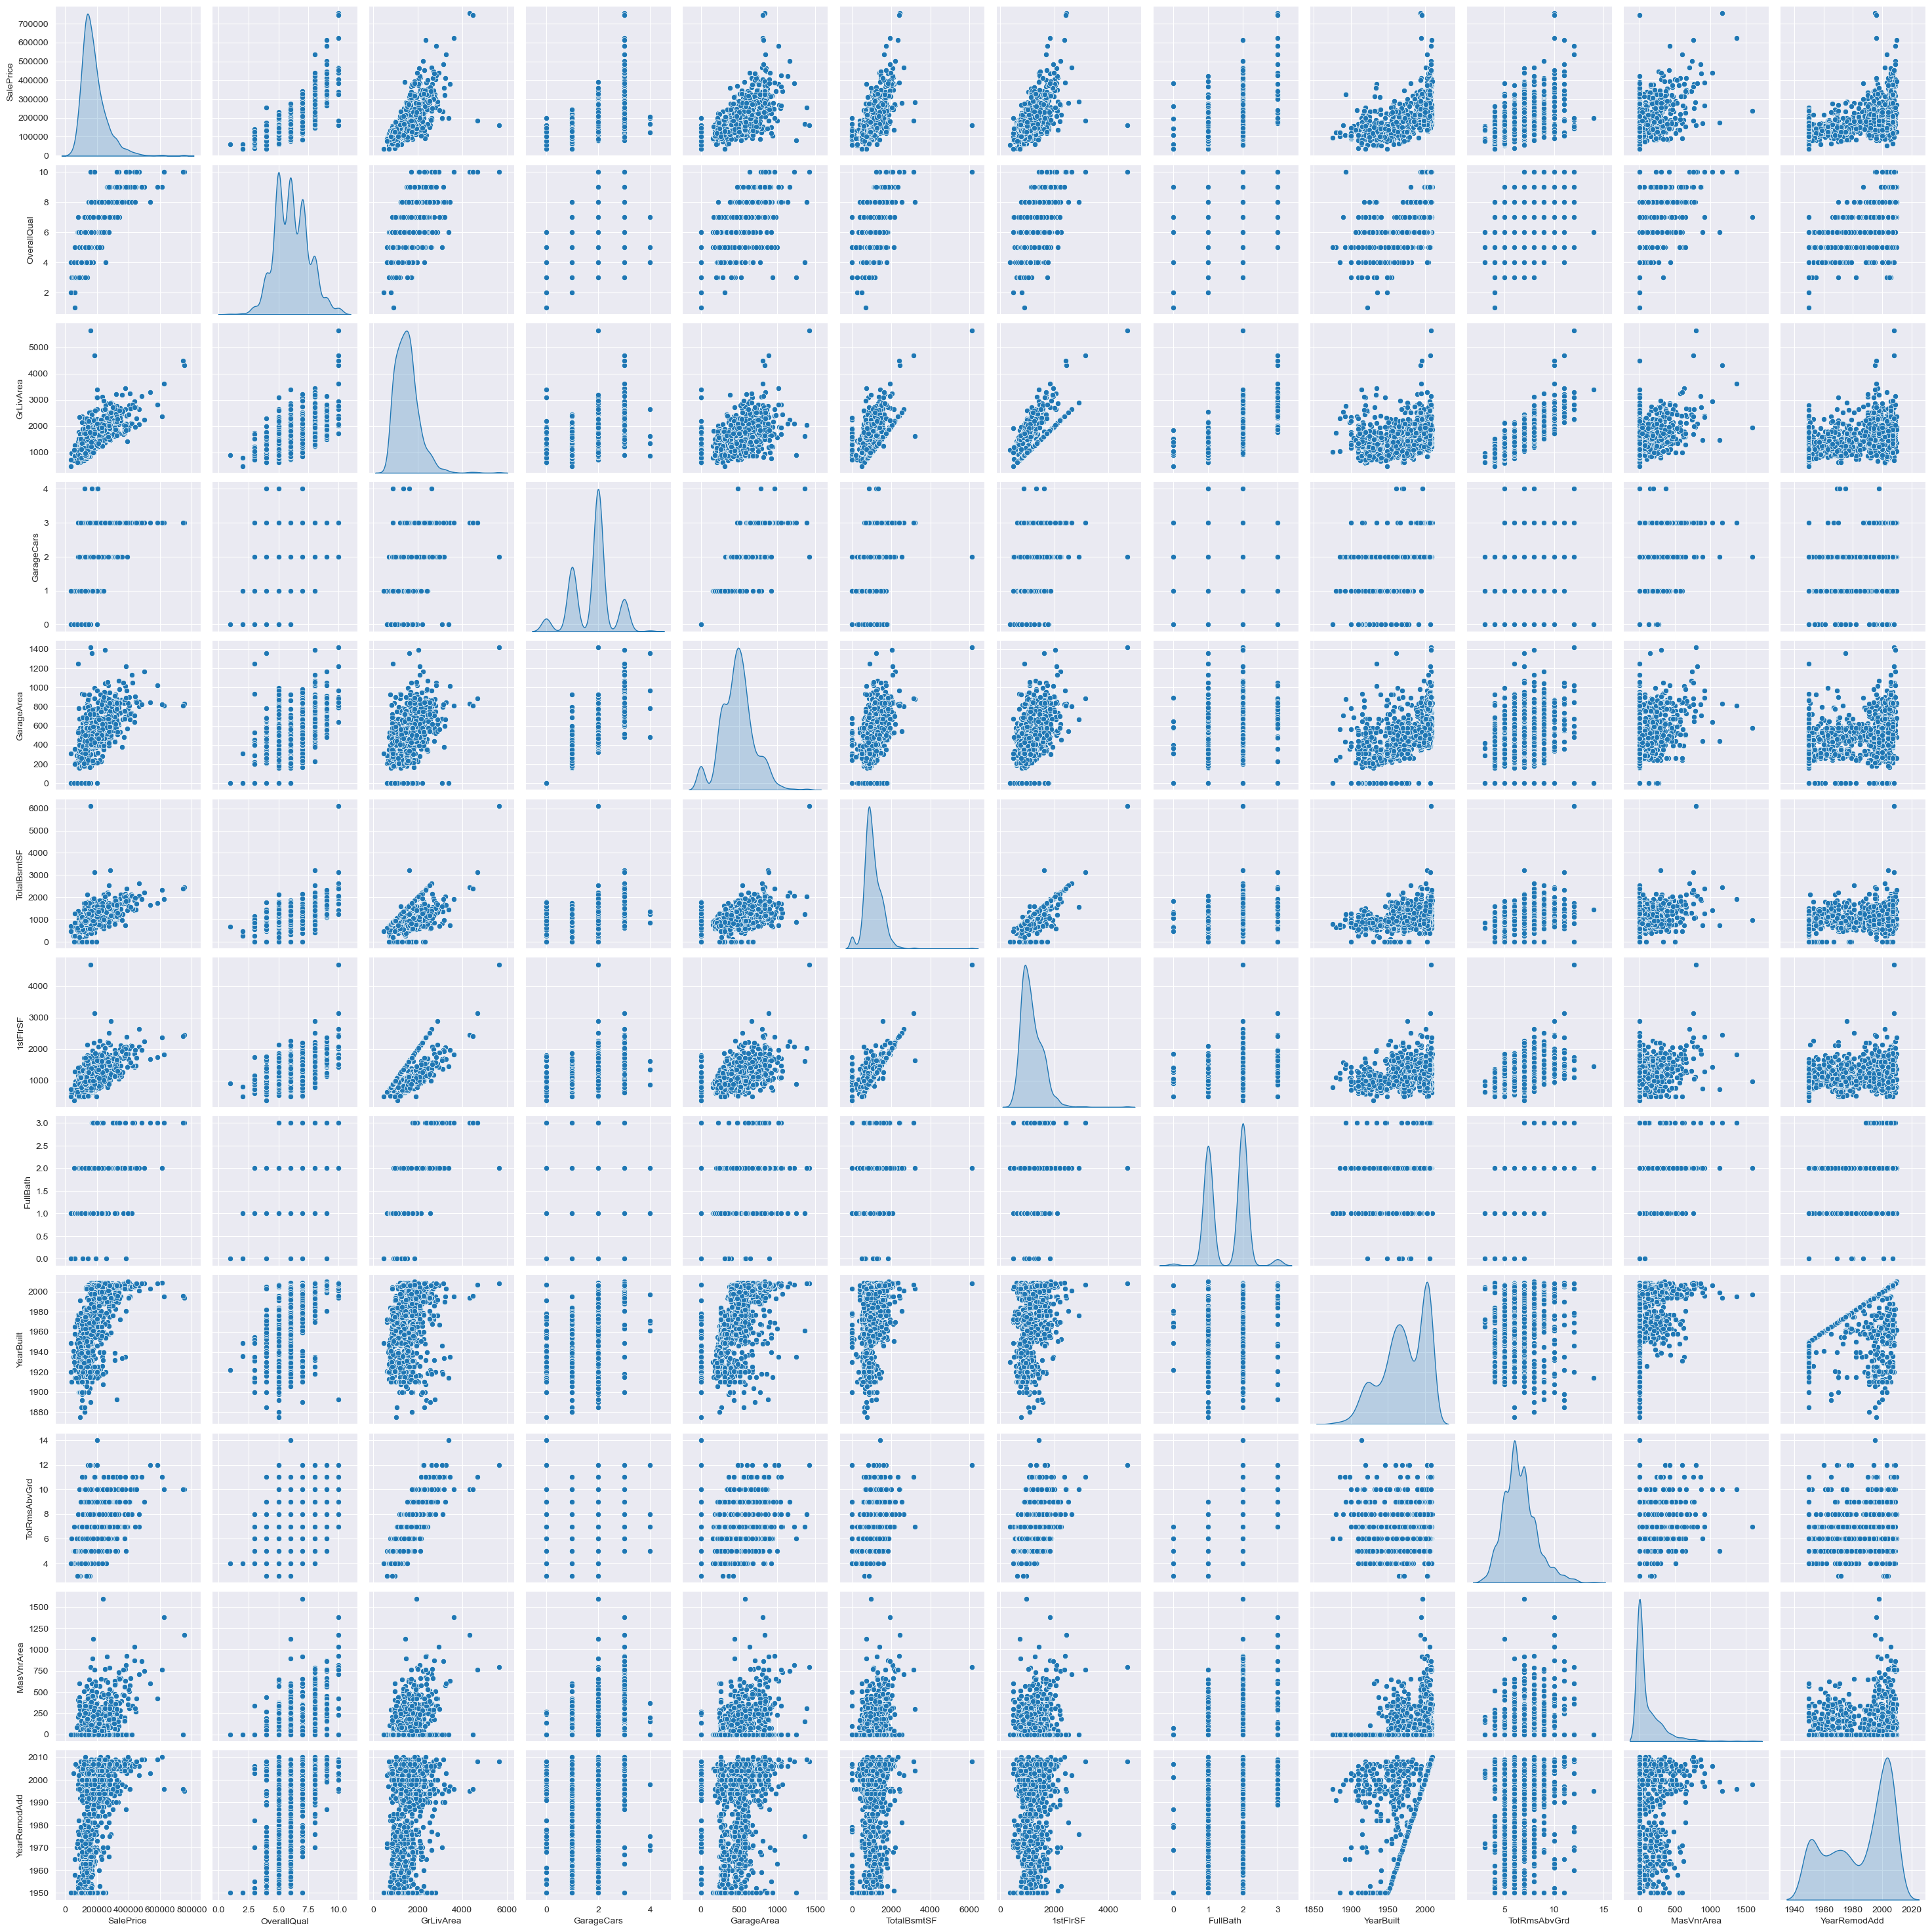

In [84]:
sns.pairplot(df_copy[significant_features], diag_kind='kde')
plt.show()

Вывод признаков с очень слабой корреляции < 0.1

In [85]:
insignificant_corr = sorted_corr[abs(sorted_corr) < 0.5]
insignificant_features = insignificant_corr.index.tolist()
insignificant_corr

GarageYrBlt      0.488523
Fireplaces       0.450374
BsmtFinSF1       0.385144
WoodDeckSF       0.344807
LotFrontage      0.344132
2ndFlrSF         0.342083
OpenPorchSF      0.311695
HalfBath         0.304381
LotArea          0.272889
BsmtFullBath     0.217156
BsmtUnfSF        0.208678
BedroomAbvGr     0.176020
PoolArea         0.100642
ScreenPorch      0.094718
MoSold           0.062219
3SsnPorch        0.037843
BsmtHalfBath    -0.015972
Id              -0.017947
YrSold          -0.023251
MiscVal         -0.027913
BsmtFinSF2      -0.037987
LowQualFinSF    -0.049415
MSSubClass      -0.095653
OverallCond     -0.105168
EnclosedPorch   -0.144623
KitchenAbvGr    -0.145863
Name: SalePrice, dtype: float64

## Комбинации атрибутов

In [86]:
df_copy['total_area_1_2_feet_floors'] = df_copy['TotalBsmtSF'] + df_copy['1stFlrSF'] + df_copy['2ndFlrSF']

In [87]:
df_copy[['total_area_1_2_feet_floors']]

,total_area_1_2_feet_floors
552,3426
782,2843
500,1890
1196,2742
1031,3509
...,...
665,3342
72,2550
1317,2704
921,3472


In [88]:
corr_matrix = df_copy.corr(numeric_only=True)
sorted_corr = corr_matrix["SalePrice"].sort_values(ascending=False)
significant_corr = sorted_corr[abs(sorted_corr) > 0.5]
significant_features = significant_corr.index.tolist()
significant_corr

SalePrice                     1.000000
OverallQual                   0.789719
total_area_1_2_feet_floors    0.769942
GrLivArea                     0.710609
GarageCars                    0.643041
GarageArea                    0.627645
TotalBsmtSF                   0.593863
1stFlrSF                      0.592689
FullBath                      0.559684
YearBuilt                     0.543965
TotRmsAbvGrd                  0.530728
MasVnrArea                    0.506974
YearRemodAdd                  0.502947
Name: SalePrice, dtype: float64

# Подготовка данных

Разделение предсказаний и меток

In [89]:
housing = strat_train_set.drop('SalePrice', axis=1)
housing_labels = strat_train_set['SalePrice'].copy()

Разделить данные на числовые и категориальные атрибуты

In [90]:
num_attribs = housing.select_dtypes(np.number)
num_attribs.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [91]:
cat_attribs = housing.select_dtypes(object)
cat_attribs.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

## Очистка данных

### Числовые атрибуты

In [92]:
housing.drop(['Id'], axis=1, inplace=True) # Удаляем столбец Id

Пустые значения в %

In [93]:
col_null(num_attribs)

LotFrontage    17.893836
GarageYrBlt     5.051370
MasVnrArea      0.599315
dtype: float64

Заполнения пустых значений используем **SimpleImputer** для заполнения медианным значением. **StandardScaler** для нормализации значений.

In [94]:
default_num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

Если функция имеет длинный и тяжелый _хвост_, такой как степенное распределение, то может помочь замена функции на ее логарифм. Будем применять **log_pipeline**

In [95]:
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

### Обработка текстовых и категориальных атрибутов

Пустые значения в %

In [96]:
col_null(cat_attribs)

PoolQC          99.486301
MiscFeature     96.404110
Alley           93.835616
Fence           80.308219
MasVnrType      59.075342
FireplaceQu     47.688356
GarageType       5.051370
GarageFinish     5.051370
GarageQual       5.051370
GarageCond       5.051370
BsmtExposure     2.739726
BsmtFinType2     2.739726
BsmtQual         2.654110
BsmtCond         2.654110
BsmtFinType1     2.654110
Electrical       0.085616
dtype: float64

Функция замена NaN на None

In [97]:
def replace_nan_none(df):
    for column in df.columns:
        df[column] = df[column].fillna("None")
    return df

In [98]:
replace_nan_none(cat_attribs)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
552,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
782,RL,Pave,None,IR2,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
500,RM,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Normal
1196,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,BuiltIn,Fin,TA,TA,Y,None,None,None,New,Partial
1031,RL,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Norm,...,Basment,Fin,TA,TA,Y,None,None,None,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
72,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,...,Attchd,Fin,TA,TA,Y,None,None,None,WD,Normal
1317,FV,Pave,Pave,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,New,Partial
921,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,...,None,None,None,None,N,None,GdPrv,None,WD,Normal


In [99]:
cat_pipeline = make_pipeline(
    FunctionTransformer(replace_nan_none),
    LabelEncoder())

### Конвейеры преобразования

In [100]:
housing['total_area_1_2_feet_floors'] = housing['TotalBsmtSF'] + housing['1stFlrSF'] + housing['2ndFlrSF']

preprocessing = ColumnTransformer([
    ('log', log_pipeline, ['LotFrontage', 'BsmtUnfSF', 'GrLivArea', 'total_area_1_2_feet_floors']),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object)),
], remainder=default_num_pipeline)